In [1]:
import os, sys
cwd = os.getcwd()
project_path = cwd[:cwd.find('pygents')+7]
if project_path not in sys.path: sys.path.append(project_path)
os.chdir(project_path) 

import math
import pandas as pd
import numpy as np
import random

from sklearn.cluster import DBSCAN
from sklearn.cluster import KMeans
from sklearn import metrics
from sklearn.datasets import make_blobs
from sklearn.preprocessing import StandardScaler

from sklearn.cluster import DBSCAN
from sklearn import metrics
from sklearn.datasets import make_blobs
from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt


### TODO

- market space
  - metrics
      - trend (price change trend)
      - level based on average (variance/deviation from mean)
      - range and std (measuring volatility)
  - sources
      - price
      - volume (trade, buy, sell)
  - in different horizons - sec, min, hour day
  - with different averages of all of that in these ranges
  


In [2]:
#OLD
def frame_normalize(df,column):
    label = column + 'N'
    df[label] = df[column] / df[column].abs().max()
def frame_diffnorm(df,column):
    label = column + 'DN'
    s = df[column]
    diff = s.diff()
    df[label] = diff/diff.abs().max()

    
#NEW
def frame_trend(df,column,n,norm=True):
    label = column + 'T' + str(n) + ('N' if norm else '')
    diffmean = df[column].diff().rolling(window=n,center=False,win_type='triang').mean()
    if norm:
        diffmean = diffmean / diffmean.abs().max()
    df[label] = diffmean

def frame_level(df,column,n,norm=True):
    label = column + 'V' + str(n) + ('N' if norm else '')
    variance = df[column] - df[column].rolling(window=n,center=False,win_type='triang').mean()
    if norm:
        variance = variance / variance.abs().max()
    df[label] = variance

def frame_range(df,column,n,norm=True):
    label = column + 'R' + str(n) + ('N' if norm else '')
    vmax = df[column].rolling(window=n,center=False).max()
    vmin = df[column].rolling(window=n,center=False).min()
    volatility = vmax - vmin
    if norm:
        volatility = volatility / volatility.abs().max()
    df[label] = volatility

def frame_std(df,column,n,norm=True):
    label = column + 'S' + str(n) + ('N' if norm else '')
    std = df[column].rolling(window=n,center=False).std()
    if norm:
        std = std / std.abs().max()
    df[label] = std

  

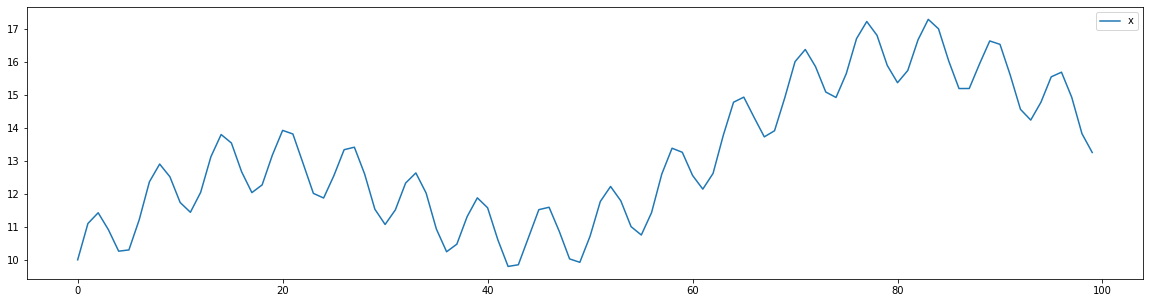

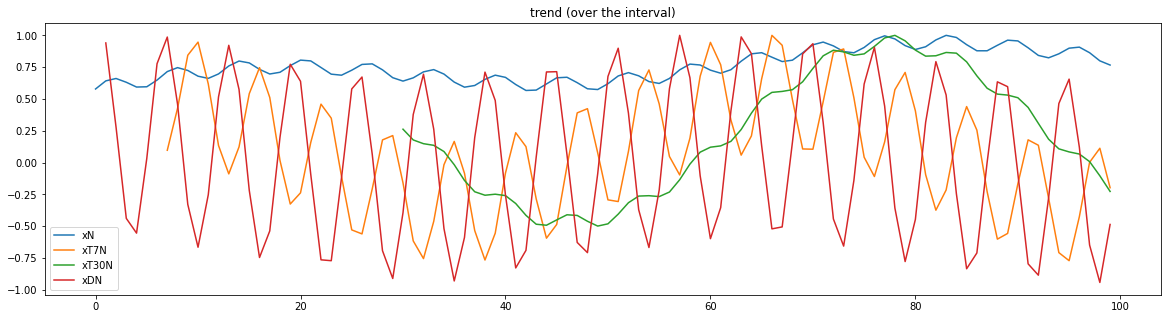

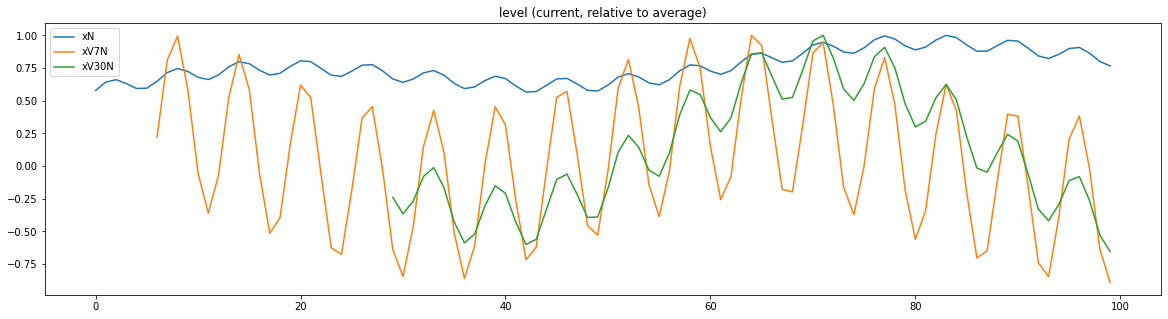

In [3]:
plt.rcParams["figure.figsize"] = (20,5)
x_df = pd.DataFrame([10+math.sin(i)+math.sin(i*0.1)*2+math.sin(i*0.01)*5+math.sin(i*0.001)*10 for i in range(0,100)],
                    columns=['x'])
p = x_df.plot()

frame_normalize(x_df,'x')
frame_diffnorm(x_df,'x')

frame_trend(x_df,'x',7)
frame_trend(x_df,'x',30)
p = x_df[['xN','xT7N','xT30N','xDN']].plot(title = 'trend (over the interval)')

frame_level(x_df,'x',7)
frame_level(x_df,'x',30)
p = x_df[['xN','xV7N','xV30N']].plot(title = 'level (current, relative to average)')


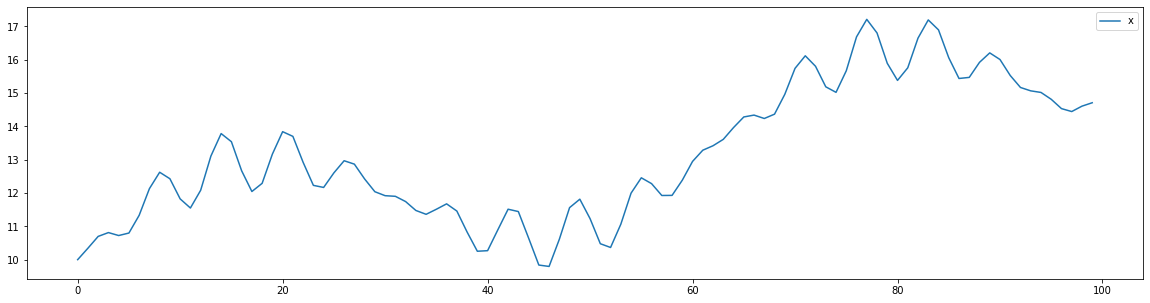

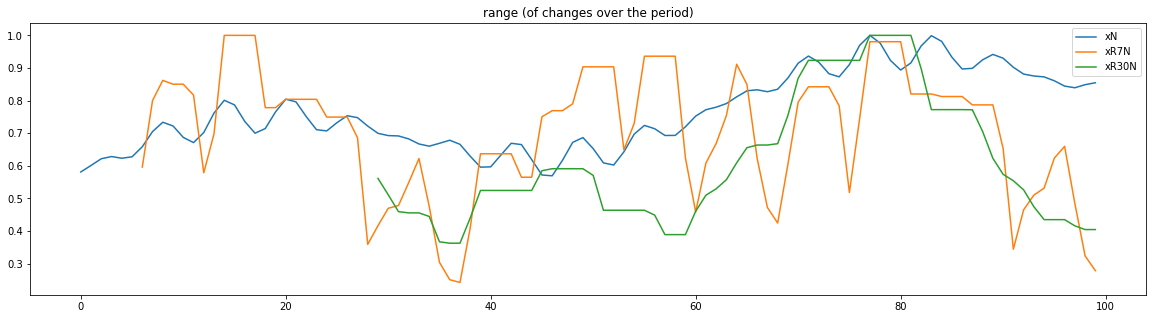

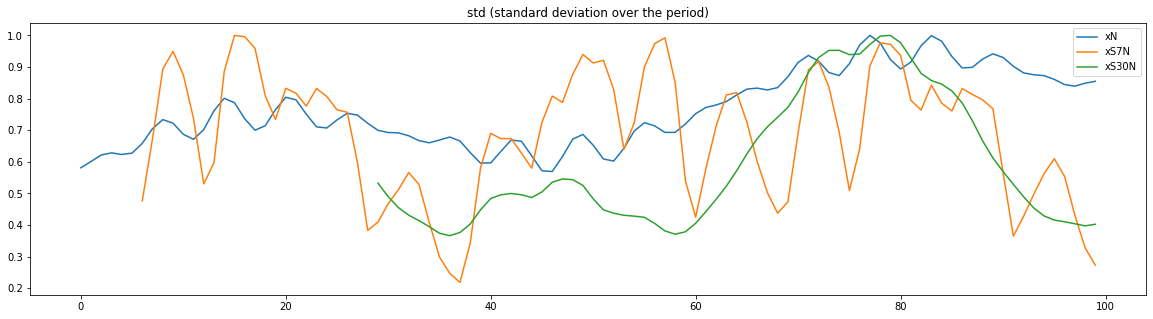

In [4]:
plt.rcParams["figure.figsize"] = (20,5)
x_df = pd.DataFrame([10+math.sin(i)*math.sin(i*0.1)+math.sin(i*0.1)*2+math.sin(i*0.01)*5+math.sin(i*0.001)*10 for i in range(0,100)],
                    columns=['x'])
p = x_df.plot()
frame_normalize(x_df,'x')

frame_range(x_df,'x',7,norm=True)
frame_range(x_df,'x',30,norm=True)
p = x_df[['xN','xR7N','xR30N']].plot(title = 'range (of changes over the period)')

frame_std(x_df,'x',7,norm=True)
frame_std(x_df,'x',30,norm=True)
p = x_df[['xN','xS7N','xS30N']].plot(title = 'std (standard deviation over the period)')


In [5]:
x_df

,x,xN,xR7N,xR30N,xS7N,xS30N
0,10.000000,0.580924,NaN,NaN,NaN,NaN
1,10.343673,0.600889,NaN,NaN,NaN,NaN
2,10.697981,0.621472,NaN,NaN,NaN,NaN
3,10.812722,0.628137,NaN,NaN,NaN,NaN
4,10.724070,0.622987,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...
95,14.813999,0.860581,0.623413,0.434584,0.609487,0.415457
96,14.534365,0.844337,0.659474,0.434584,0.553667,0.410098
97,14.446224,0.839216,0.484207,0.415569,0.431116,0.403798
98,14.608093,0.848620,0.323324,0.404145,0.327636,0.397178


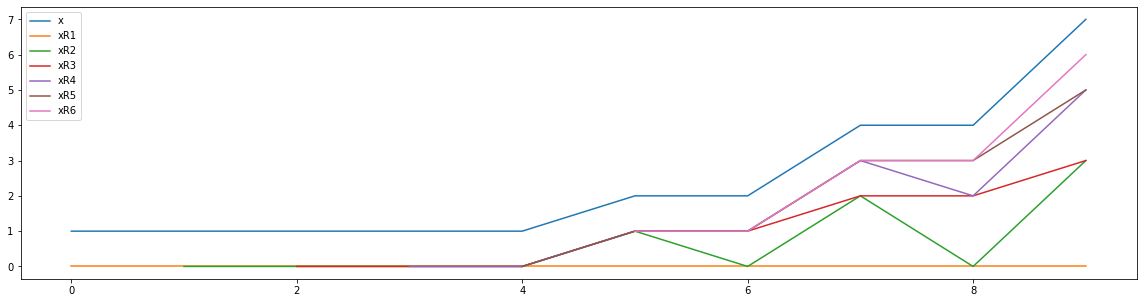

In [6]:
y_df = pd.DataFrame([1,1,1,1,1,2,2,4,4,7],columns=['x'])
frame_range(y_df,'x',1,norm=False)
frame_range(y_df,'x',2,norm=False)
frame_range(y_df,'x',3,norm=False)
frame_range(y_df,'x',4,norm=False)
frame_range(y_df,'x',5,norm=False)
frame_range(y_df,'x',6,norm=False)
p = y_df.plot()
